In [13]:
%run "examples/simulate_networks.py" # Modify this line to be /to/path/jf2016-tutorial/examples/simulate_networks.py

In [14]:
%matplotlib inline
# Import from skggm
import inverse_covariance as ic
from inverse_covariance import (
    QuicGraphLasso,
    QuicGraphLassoCV,
    QuicGraphLassoEBIC,
    AdaptiveGraphLasso,
    ModelAverage
)
from inverse_covariance.plot_util import trace_plot 

In [15]:
# Notebook wide settings
n_features = 15
adj_type = 'banded'

# Contents
1. [Part I. Setup & Motivation](#part1)
2. [Part II. Sparse MLE](#part2)
3. [Part III. Compare Estimators](#part3)
4. [Part IV. Model Averaging](#part4)

[If kernel dies, go here](#restart)


<a id='part1'></a>
## Part I. Setup & Motivation

### Create Simulated Network

<string>:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


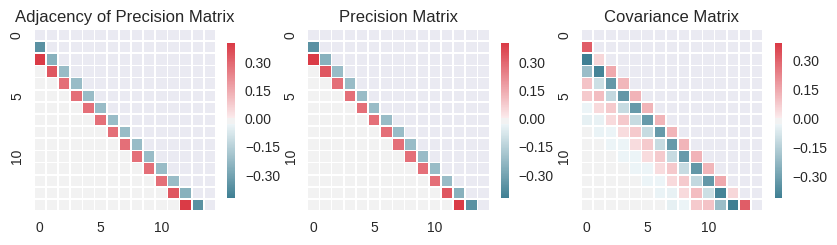

In [16]:
%matplotlib inline
covariance, precision, adjacency = new_graph(15,.15,adj_type=adj_type,random_sign=True,seed=1)    
covariance2, precision2, adjacency2 = new_graph(15,.2,adj_type=adj_type,random_sign=True, seed=1)    

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

def compare_population_parameters(covariance,precision,adjacency):
    mask = np.zeros_like(precision, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.where(np.eye(np.shape(precision)[0]))] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    adj_vmax = np.max(np.triu(adjacency,1))
    sns.heatmap(adjacency,mask=mask,cmap=cmap, vmax=adj_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
    ax1.set_title('Adjacency of Precision Matrix')

    prec_vmax = np.max(np.triu(precision,1))
    sns.heatmap(precision,mask=mask,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
    ax2.set_title('Precision Matrix')

    cov_vmax = np.max(np.triu(covariance,1))
    sns.heatmap(covariance, mask=mask,cmap=cmap, vmax=cov_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax3)
    ax3.set_title('Covariance Matrix')
    
compare_population_parameters(covariance,precision,adjacency)    

<a id='restart'></a>
### If kernel dies. 
Go to cells and choose 'Run All Above' *this* cell

### Example of Degeneracy in High Dimensions

Suppose we have two graphs that vary slightly in their degree. For example one with nodes with degree $=2$ and another with degree $=3$. 

- At large sample sizes, their sample covariances are distinguishable and a simple inverse precision matrix captures the original structure. 
- At small sample sizes both sample covariances and their precision counterparts become indistinguishable. 

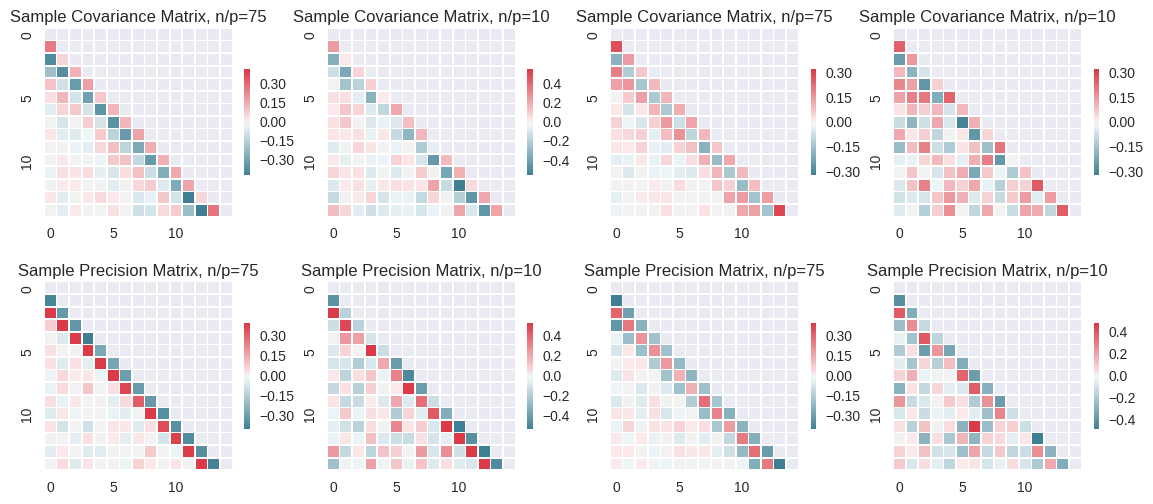

In [8]:
%matplotlib inline

prng = np.random.RandomState(2)
X1 = mvn(75*n_features,n_features,covariance,random_state=prng)
X2 = mvn(10*n_features,n_features,covariance,random_state=prng)
X3 = mvn(75*n_features,n_features,covariance2,random_state=prng)
X4 = mvn(10*n_features,n_features,covariance2,random_state=prng)

mask = np.zeros_like(precision, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.where(np.eye(np.shape(precision)[0]))] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ([ax1, ax2, ax5, ax7], [ax3, ax4, ax6, ax8]) = plt.subplots(2,4,figsize=(14,6));
cov_vmax = np.max(np.triu(covariance,1))
sns.heatmap(np.tril(np.cov(X1,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Sample Covariance Matrix, n/p=75')
sns.heatmap(np.tril(np.cov(X2,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Sample Covariance Matrix, n/p=10')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X1,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Sample Precision Matrix, n/p=75')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X2,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax4)
ax4.set_title('Sample Precision Matrix, n/p=10')
sns.heatmap(np.tril(np.cov(X3,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax5)
ax5.set_title('Sample Covariance Matrix, n/p=75')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X3,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax6)
ax6.set_title('Sample Precision Matrix, n/p=75')
sns.heatmap(np.tril(np.cov(X4,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax7)
ax7.set_title('Sample Covariance Matrix, n/p=10')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X4,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax8)
ax8.set_title('Sample Precision Matrix, n/p=10')

## Part II. Sparse Inverse Covariance via Penalized MLE
<a id='part2'></a>

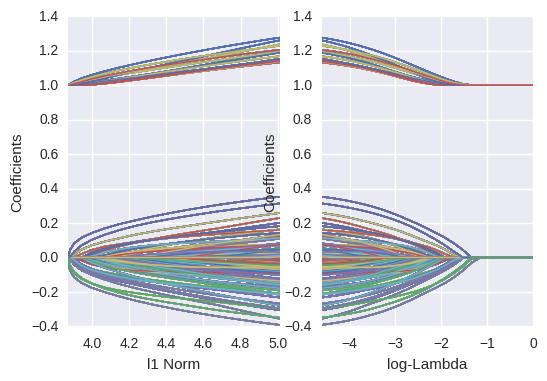

Press any key to continue.


In [ ]:
%matplotlib inline
# show graphical lasso path 
covariance, precision, adjacency = new_graph(15,.2,adj_type=adj_type,random_sign=True,seed=1)    
prng = np.random.RandomState(2)
X = mvn(20*n_features,n_features,covariance,random_state=prng)
path = np.logspace(np.log10(0.01), np.log10(1.0), num=25, endpoint=True)[::-1]
estimator = QuicGraphLasso(lam=1.0,path=path,mode='path')
estimator.fit(X)
trace_plot(estimator.precision_, estimator.path_)

### Model Selection: Cross-Validation versus EBIC

In [3]:
metric='log_likelihood';
covariance, precision, adjacency = new_graph(n_features,.05,adj_type='banded',random_sign=True,seed=1) # BUG:Might fail with other graphs   
prng = np.random.RandomState(2)
X = mvn(10*n_features,n_features,covariance,random_state=prng)

print 'QuicGraphLassoCV with:'
print '   metric: {}'.format(metric)
cv_model = QuicGraphLassoCV(
        cv=2, 
        n_refinements=6,
        n_jobs=1,
        init_method='cov',
        score_metric=metric)
cv_model.fit(X)
cv_precision_ = cv_model.precision_
print '   len(cv_lams): {}'.format(len(cv_model.cv_lams_))
print '   lam_scale_: {}'.format(cv_model.lam_scale_)
print '   lam_: {}'.format(cv_model.lam_)

# EBIC
gamma = .1 # gamma = 0 equivalent to BIC and gamma=.5 for ultra high dimensions
ebic_model = QuicGraphLassoEBIC(
    lam=1.0,
    init_method='cov',
    gamma = gamma)
ebic_model.fit(X)
ebic_precision_ = ebic_model.precision_
print 'QuicGraphLassoEBIC with:'
print '   len(path lams): {}'.format(len(ebic_model.path_))
print '   lam_scale_: {}'.format(ebic_model.lam_scale_)
print '   lam_: {}'.format(ebic_model.lam_)

/projects/sage/sage-7.3/local/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
<string>:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


QuicGraphLassoCV with:
   metric: log_likelihood
   len(cv_lams): 25
   lam_scale_: 1.2916232883
   lam_: 0.00830110422792
QuicGraphLassoEBIC with:
   len(path lams): 100
   lam_scale_: 1.2916232883
   lam_: 0.0811223308565


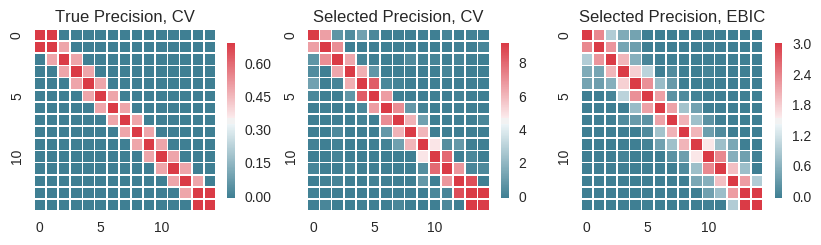

In [4]:
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

mask = np.zeros_like(precision, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.where(np.eye(np.shape(precision)[0]))] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

prec_vmax = np.max(np.triu(np.abs(adjacency),1))
sns.heatmap(np.abs(adjacency),cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('True Precision, CV')

prec_vmax = np.max(np.triu(np.abs(cv_precision_),1))
sns.heatmap(np.abs(cv_precision_),cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Selected Precision, CV')

prec_vmax = np.max(np.triu(np.abs(ebic_precision_),1))
sns.heatmap(np.abs(ebic_precision_),cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Selected Precision, EBIC')

## Part III. Compare Estimators: Initial vs. Adaptive
<a id='part3'></a>

### Initial vs. Adaptive, High Sample Size

<string>:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


n = 1125,p = 15
Difference in sparsity: 69,141
Frob Norm: 0.346975151006 (0.794759445257), Support Error: 36.0, False Pos: 36.0, False Neg: 0.0
Difference in sparsity: 69,77
Frob Norm: 0.494914088155 (0.714315303842), Support Error: 4.0, False Pos: 4.0, False Neg: 0.0



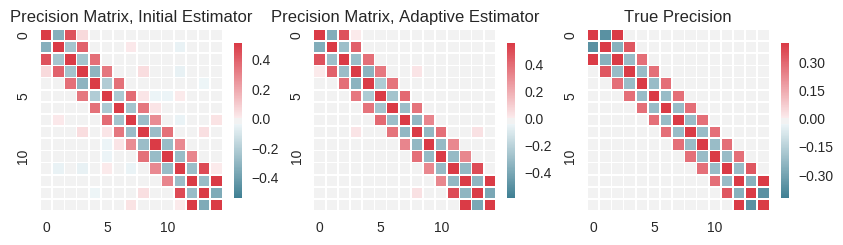

In [9]:
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

covariance, precision, adjacency = new_graph(15,.15,adj_type=adj_type,random_sign=True,seed=1)    
n_samples = 75*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

print 'n = {},p = {}'.format(n_samples,n_features)

def compare_init_adaptive(X,n_samples,n_features):
    # Initial Estimator
    initial_estimator = QuicGraphLassoCV(init_method='corrcoef')
    initial_estimator.fit(X)
    prec_hat = initial_estimator.precision_
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    prec_vmax = np.max(np.triu(prec_hat,1))
    sns.heatmap(initial_estimator.precision_,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
    ax1.set_title('Precision Matrix, Initial Estimator')
    # Check Average Power
    err_frob, err_supp, err_fp, err_fn, err_inf =  ae_trial(
        trial_estimator=initial_estimator,
        n_samples=n_samples, 
        n_features=n_features, 
        cov=covariance, 
        adj=adjacency, 
        random_state=np.random.RandomState(2),X=X)
    print 'Difference in sparsity: {},{}'.format(
        np.sum(np.not_equal(precision,0)), 
        np.sum(np.not_equal(initial_estimator.precision_,0))
    )
    print 'Frob Norm: {} ({}), Support Error: {}, False Pos: {}, False Neg: {}'.format(
        err_frob, err_inf,
        err_supp,
        err_fp,
        err_fn
    )   
    # Adaptive Estimator
    twostage = AdaptiveGraphLasso(estimator=initial_estimator,method='inverse')
    twostage.fit(X)
    weighted_estimator = twostage.estimator_

    prec_hat = weighted_estimator.precision_
    prec_vmax = np.max(np.triu(prec_hat,1))
    sns.heatmap(weighted_estimator.precision_,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
    ax2.set_title('Precision Matrix, Adaptive Estimator')
    print 'Difference in sparsity: {},{}'.format(
        np.sum(np.not_equal(precision,0)), 
        np.sum(np.not_equal(weighted_estimator.precision_,0))
    )
    # Check Average Power
    err_frob, err_supp, err_fp, err_fn, err_inf =  ae_trial(
        trial_estimator=weighted_estimator,
        n_samples=n_samples, 
        n_features=n_features, 
        cov=covariance, 
        adj=adjacency, 
        random_state=np.random.RandomState(2), X = X)
    print 'Frob Norm: {} ({}), Support Error: {}, False Pos: {}, False Neg: {}'.format(
        err_frob,err_inf,
        err_supp,
        err_fp,
        err_fn
    )
    print 
    prec_vmax = np.max(np.triu(precision,1))
    sns.heatmap(adjacency,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
    ax3.set_title('True Precision')

compare_init_adaptive(X,n_samples,n_features)



### Initial vs. Adaptive, Low Sample Size

n = 225,p = 15
Difference in sparsity: 69,151
Frob Norm: 0.561547216143 (0.897813495593), Support Error: 41.0, False Pos: 41.0, False Neg: 0.0
Difference in sparsity: 69,97
Frob Norm: 0.664876836748 (1.04868877247), Support Error: 14.0, False Pos: 14.0, False Neg: 0.0



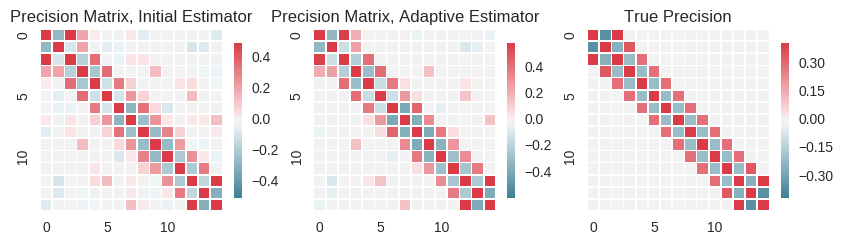

In [10]:
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

n_samples = 15*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print 'n = {},p = {}'.format(n_samples,n_features)
compare_init_adaptive(X,n_samples,n_features)


### Initial vs. Adaptive in Moderately Dense Graphs

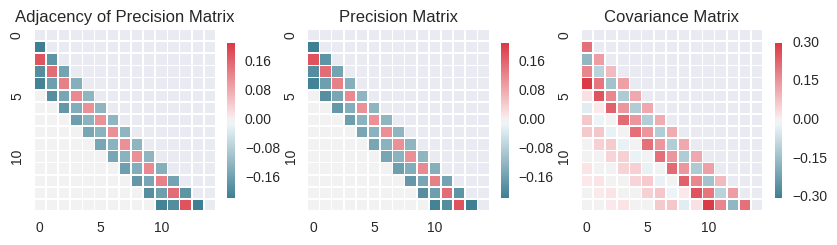

In [17]:
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));
covariance, precision, adjacency = new_graph(15,.4,adj_type=adj_type,random_sign=True,seed=1)    
compare_population_parameters(covariance,precision,adjacency)    

### High Sample Size

n = 1125,p = 15
Difference in sparsity: 115,169
Frob Norm: 0.312412241868 (0.520746458498), Support Error: 27.0, False Pos: 27.0, False Neg: 0.0
Difference in sparsity: 115,129
Frob Norm: 0.344734857898 (0.599308645621), Support Error: 7.0, False Pos: 7.0, False Neg: 0.0



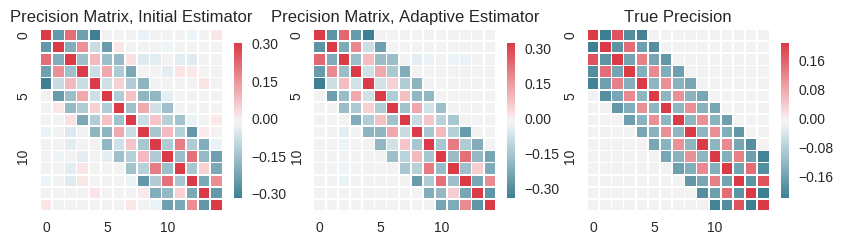

In [18]:
%matplotlib inline
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

n_samples = 75*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print 'n = {},p = {}'.format(n_samples,n_features)

compare_init_adaptive(X,n_samples,n_features)

### Low Sample Size

n = 300,p = 15
Difference in sparsity: 115,135
Frob Norm: 0.567170517426 (1.02509054493), Support Error: 22.0, False Pos: 16.0, False Neg: 6.0
Difference in sparsity: 115,111
Frob Norm: 0.702817766604 (1.40414502038), Support Error: 18.0, False Pos: 8.0, False Neg: 10.0



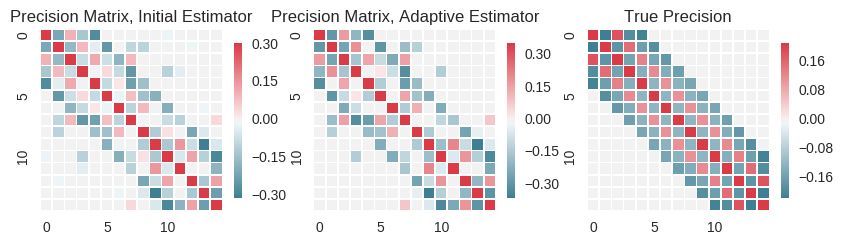

In [19]:
%matplotlib inline
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

n_samples = 20*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print 'n = {},p = {}'.format(n_samples,n_features)

compare_init_adaptive(X,n_samples,n_features)

## Part IV Model Averaging
<a id='part4'></a>

Bootstrap the data matrix, estimate the inverse covariance and then aggregate the zero/non-zero pattern across all resampled estimates.
This gives you a binomial proportion matrix normalized to (0,1) range. Each entry of the proportion gives you a confidence score of how likely an edge is in the model. 
- High proportion indicates stable presence under model perturbations
- Low proportion either indicates lack of signal strength or absence of an edge

In [20]:
covariance, precision, adjacency = new_graph(15,.15,adj_type=adj_type,random_sign=True,seed=1)    
n_samples = 15*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

ensemble_estimator = ModelAverage(
            n_trials=50,
            penalization='fully-random',
            lam=0.15)
ensemble_estimator.fit(X)

covariance, precision, adjacency = new_graph(15,.3,adj_type=adj_type,random_sign=True,seed=1)    
n_samples = 15*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

ensemble_estimator2 = ModelAverage(
            n_trials=50,
            penalization='fully-random',
            lam=0.15)
ensemble_estimator2.fit(X)

Difference in sparsity: 93,75
Support Error:, False Pos: 3.0, False Neg: 12.0
Difference in sparsity: 93,23
Support Error:, False Pos: 0.0, False Neg: 35.0


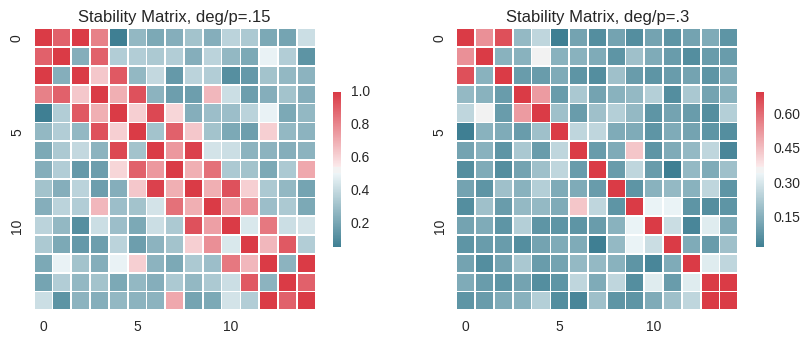

In [21]:
%matplotlib inline
# Plot comparison
f, (ax2, ax3) = plt.subplots(1,2, figsize=(10, 4));

stability_threshold = .5
prec_hat = ensemble_estimator.proportion_
prec_vmax = np.max(np.triu(prec_hat,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(prec_hat,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Stability Matrix, deg/p=.15')
print 'Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(prec_hat>stability_threshold,0))
)
err_fp, err_fn = _false_support(precision,np.greater(ensemble_estimator.proportion_,stability_threshold))
print 'Support Error:, False Pos: {}, False Neg: {}'.format(
    err_fp,
    err_fn
)
 
prec_hat = ensemble_estimator2.proportion_
prec_vmax = np.max(np.triu(prec_hat,1))
sns.heatmap(prec_hat,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Stability Matrix, deg/p=.3')
print 'Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(prec_hat>stability_threshold,0))
)
err_fp, err_fn = _false_support(precision,np.greater(ensemble_estimator2.proportion_,stability_threshold))
print 'Support Error:, False Pos: {}, False Neg: {}'.format(
    err_fp,
    err_fn
)